## Survival Analysis: Based on Gradient Boosting Machine(GBM)

The tutorial give typical workflow of Gradient Boosting Desicion Tree-based survival analysis including data-preprocessing, model selection and traning&validation, uses R package `gbm`.

Formally, it can be listed by:
1. Data Preprocessing
  - convert variables
  - load training and test set
2. Model Selection
  - cross validation
  - tune parameters
3. Traning&Validation
  - train gbm model
  - measure CI on testset
  - survival rates on time of interest
  
The best suggestion about usage of `gbm` is official documentation named **"Generalized Boosted Models:A guide to the gbm package"**. Here, I summary some points related to usage of the package and SA, and disscussion of options to gbm that most users will need to change or tune.

### 1. Loss Function

`distribution` is corresponding to loss function and application. Here, the option `coxph` indicating SA should be selected.

### 2. Model Fitting

`shrinkage` and `n.trees` are mostly related to performance, so those should be tuned carefully.

As recommended by author of `gbm`, it is generally the case that for small shrinkage parameters, 0.001 for example.
>  My rule of thumb is to set shrinkage as small as possible while still being able to fit the model in a reasonable amount of time and storage. I usually aim for 3,000 to 10,000 iterations with shrinkage rates between 0.01 and 0.001.

### 3. The Optimal Number of Iterations

`gbm` offers three methods for estimating the optimal number of iterations after the gbm model has been fit, an independent test set (`test`), out-of-bag estimation (`OOB`), and v-fold cross validation (`cv`). The function `gbm.perf` computes the iteration estimate.

Among these methods for estimating `n.trees`, **V-Fold Cross Validation** is the best choice.
> My recommendation is to use 5- or 10-fold cross validation if you can afford the computing time. Otherwise you may choose among the other options, knowing that OOB is conservative.

### Step0 - Load library and Data

In [1]:
library('survival')
library('gbm')
# set random state
set.seed(0)

Warning message:
"package 'gbm' was built under R version 3.5.1"Loaded gbm 2.1.4


In [2]:
data(veteran, package = "randomForestSRC")
cat("Number of samples:", nrow(veteran), "\n")
cat("Columns of dataset:", colnames(veteran), "\n")
veteran[c(1:5), ]

Number of samples: 137 
Columns of dataset: trt celltype time status karno diagtime age prior 


trt,celltype,time,status,karno,diagtime,age,prior
1,1,72,1,60,7,69,0
1,1,411,1,70,5,64,10
1,1,228,1,60,3,38,0
1,1,126,1,60,9,63,10
1,1,118,1,70,11,65,10


### Step1 - Data Preprocessing

In [3]:
# Sample the data and create a training subset.
train <- sample(1:nrow(veteran), round(nrow(veteran) * 0.80))
data_train <- veteran[train, ]
data_test <- veteran[-train, ]

### Step2 - Model Selection

The hyperparameters should be tuned as follows:
- `shrinkage` (i.e., learning_rate)
- `n.trees` (total number of trees to fit)
- `interaction.depth` (maximum depth of each tree)
- `n.minobsinnode` (minimum number of observations in the terminal nodes of the trees)

Optional Reading: You can try to search the best hyperparameters' estimation by using python package `hyperopt`.

By the means of described, repeated 4-fold cross validation on training set for 3 times is used, results of searching are:
- "n.trees": 3000
- "shrinkage": 0.005
- "interaction.depth": 2
- "n.minobsinnode": 5
- ci=0.701183(average on repeated 4-fold cross validation for 3 times)

### Step3 - Model Training & Evaluation

We will pass arguments to object `gbm` for training robust model after completing hyperparameters tuning in step2, and then validate our fitted model using test set.

Here, evaluation and more in this section includes:

- calculating CI metrics
- calculating survival function on specified time
- saving result as file

#### 3.0 - Model Training & Prediction

In [4]:
set.seed(2891)
# using training set fits gbm model
model <- gbm(Surv(time, status) ~ .,
             distribution='coxph',
             data=data_train,
             n.trees=3000,
             shrinkage=0.005,
             interaction.depth=2,
             n.minobsinnode=5,
             cv.folds=4)
# values of loss function on training set for each tree
print(model$train.error[2901:3000])

  [1] 6.272987 6.272907 6.272681 6.272755 6.272670 6.272456 6.272487 6.272337
  [9] 6.272159 6.272079 6.272006 6.271792 6.271141 6.270999 6.270618 6.270300
 [17] 6.270110 6.270016 6.269998 6.270000 6.269819 6.269646 6.269598 6.269504
 [25] 6.269357 6.269255 6.269225 6.269045 6.268980 6.268933 6.268696 6.268707
 [33] 6.268544 6.268420 6.268395 6.268200 6.268113 6.267884 6.267657 6.267704
 [41] 6.267584 6.267579 6.267789 6.267881 6.267847 6.267803 6.267657 6.267598
 [49] 6.267828 6.267691 6.267558 6.267598 6.267417 6.267321 6.267459 6.267548
 [57] 6.267511 6.267446 6.267350 6.267368 6.267399 6.267221 6.266798 6.266589
 [65] 6.266697 6.266545 6.266681 6.266773 6.266645 6.266570 6.266458 6.266259
 [73] 6.266186 6.266106 6.266010 6.266032 6.266148 6.266037 6.265965 6.265864
 [81] 6.265875 6.265634 6.265440 6.265422 6.265410 6.265237 6.265109 6.264828
 [89] 6.264833 6.264716 6.264682 6.264463 6.264373 6.264265 6.264142 6.264086
 [97] 6.263929 6.263762 6.263183 6.262952


using function `gbm.perf` to get optimal number of iterations and plotting the learning curve

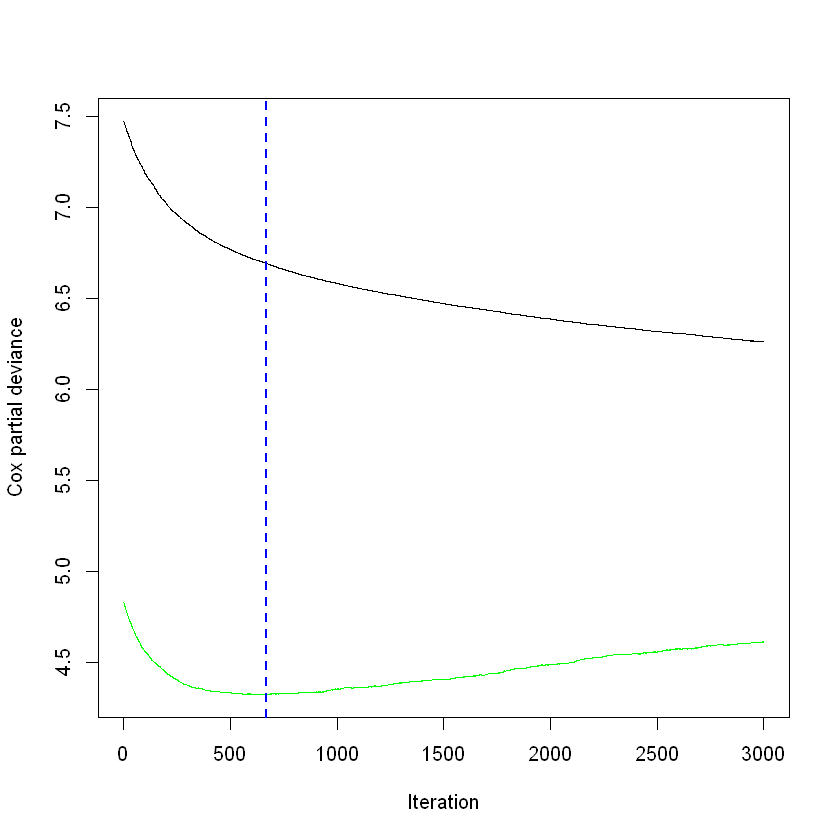

In [5]:
best.iter <- gbm.perf(model, plot.it = TRUE, method = 'cv')

In [6]:
# return a vector of prediction on n.trees indicting log hazard scale.f(x)
pred.train <- predict(model, data_train, n.trees = best.iter)
pred.test <- predict(model, data_test, n.trees = best.iter)

### 3.1 - CI (concordance index)
We can get $\text{CI}$(concordance index) by function `rcorr.cens` from package `Hmisc`.

In [7]:
Hmisc::rcorr.cens(-pred.train, Surv(data_train$time, data_train$status))

C Index            Dxy           S.D.              n        missing 
  7.801556e-01   5.603113e-01   4.835288e-02   1.100000e+02   0.000000e+00 
    uncensored Relevant Pairs     Concordant      Uncertain 
  1.020000e+02   1.130800e+04   8.822000e+03   6.260000e+02

In [8]:
Hmisc::rcorr.cens(-pred.test, Surv(data_test$time, data_test$status))

C Index            Dxy           S.D.              n        missing 
     0.6886228      0.3772455      0.1433610     27.0000000      0.0000000 
    uncensored Relevant Pairs     Concordant      Uncertain 
    26.0000000    668.0000000    460.0000000     32.0000000

#### 3.2 - Survival function

`gbm` offers method `basehaz.gbm` to estimate the cumulative baseline hazard function $\int_0^{t}\lambda(z)dz$. Since survival function can be estimated by:
$$
s(t|X)=exp{\{-\ e^{f(X)}\int_0^{t}\lambda(z)dz\}}
$$

$f(X)$ is prediction of `gbm`, which is equal to log-hazard proportion.
So we can get survival function of individuals easily.

In [9]:
# Sepecify time of interest
time.interest <- sort(unique(data_train$time[data_train$status==1]))

In [10]:
# Estimate the cumulative baseline hazard function using training data
basehaz.cum <- basehaz.gbm(data_train$time, data_train$status, pred.train, t.eval = time.interest, cumulative = TRUE)

For individual $i$ in test set, estimation of survival function is:

In [11]:
surf.i <- exp(-exp(pred.test[1])*basehaz.cum)

In [12]:
print(surf.i)

 [1] 9.927248e-01 9.890281e-01 9.852382e-01 9.736998e-01 9.575063e-01
 [6] 9.490337e-01 9.446703e-01 9.403137e-01 9.315803e-01 9.270761e-01
[11] 9.224916e-01 9.085303e-01 9.034015e-01 8.930300e-01 8.875027e-01
[16] 8.763125e-01 8.647355e-01 8.585433e-01 8.523026e-01 8.394247e-01
[21] 8.264848e-01 8.199323e-01 8.132473e-01 8.063389e-01 7.993841e-01
[26] 7.924367e-01 7.854976e-01 7.783247e-01 7.706500e-01 7.467482e-01
[31] 7.294782e-01 7.205871e-01 7.028921e-01 6.939001e-01 6.848827e-01
[36] 6.752722e-01 6.655636e-01 6.555930e-01 6.354847e-01 6.245106e-01
[41] 6.131282e-01 6.016796e-01 5.898952e-01 5.779547e-01 5.529901e-01
[46] 5.398873e-01 5.262693e-01 5.126514e-01 4.991587e-01 4.728259e-01
[51] 4.574719e-01 4.421798e-01 4.268952e-01 4.114664e-01 3.957659e-01
[56] 3.802090e-01 3.633897e-01 3.457641e-01 3.278898e-01 3.100254e-01
[61] 2.918461e-01 2.727655e-01 2.536745e-01 2.347807e-01 2.160340e-01
[66] 1.962410e-01 1.763388e-01 1.569783e-01 1.374634e-01 1.180111e-01
[71] 1.006372e-01 8.

Estimation of survival rate of all at specified time is:

In [13]:
specif.time <- time.interest[10]
cat("Survival Rate of all at time", specif.time, "\n")
surv.rate <- exp(-exp(pred.test)*basehaz.cum[10])
print(surv.rate)

Survival Rate of all at time 15 
 [1] 0.9270761 0.9502494 0.8208986 0.8573067 0.9199247 0.9378880 0.6987562
 [8] 0.9146517 0.8771222 0.9314684 0.9183110 0.8063917 0.9184431 0.9596170
[15] 0.9741025 0.9226616 0.5394012 0.6959224 0.8785593 0.9386735 0.9117690
[22] 0.9385850 0.6396585 0.8981364 0.9315653 0.9039892 0.9397032


#### 3.3 - Saving as file

Here, we concate test data and prediction, survival rate, and then convert it to csv file.

In [14]:
res_test <- data_test
# predicted outcome for test set
res_test$pred <- pred.test
res_test$survival_rate <- surv.rate
# Save data
write.csv(res_test, file = "result_gbm.csv")